#### random forest

* can create biased trees when certain classes dominate in a dataset. balance the dataset before fitting
* can overfit on data with many features. PCA, feature selection reduce dimensionality
* minimal data preparation, but missing values should be handled beforehand and categorical variables encoded
* robust to outliers

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

from io import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image, display

In [2]:
df = pd.read_csv("churn.csv")
df = df.dropna()
df.head(1)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female            0.0     Yes         No     1.0           No   

      MultipleLines InternetService OnlineSecurity  ... StreamingTV  \
0  No phone service             DSL             No  ...          No   

  StreamingMovies        Contract PaperlessBilling     PaymentMethod  \
0              No  Month-to-month              Yes  Electronic check   

  MonthlyCharges TotalCharges numAdminTickets  numTechTickets  Churn  
0          29.85        29.85             0.0             0.0     No  

[1 rows x 23 columns]

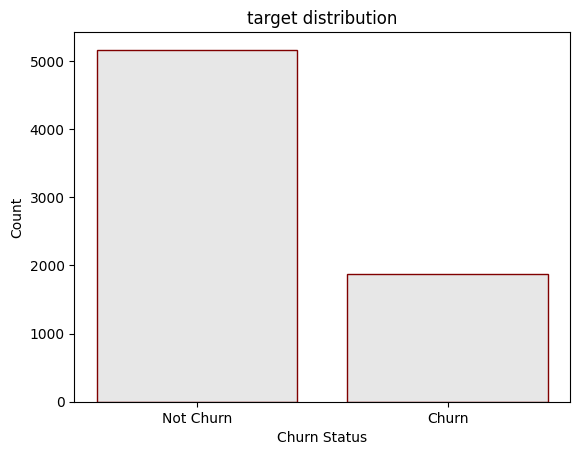

In [3]:
churn_counts = df['Churn'].value_counts()
bars = ['Not Churn', 'Churn']
height = [churn_counts[0], churn_counts[1]]

x_pos = range(len(bars))
plt.bar(x_pos, height, color=(0.1, 0.1, 0.1, 0.1), edgecolor='maroon')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks(x_pos, bars)
plt.title('target distribution')
plt.show()   

##### label encoding

In [4]:
X, Y = df.drop(columns = ['Churn','customerID']), df['Churn']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Y)
y = pd.Series(y)

#### deciphering the labels

In [5]:
y_encoded = label_encoder.fit_transform(Y)
mapping = dict(zip(Y, y_encoded))
for class_label, encoded_value in mapping.items():
    print(f"Original Class: {class_label} -> Encoded Value: {encoded_value}")

Original Class: No -> Encoded Value: 0
Original Class: Yes -> Encoded Value: 1


#### train/test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

#### [resample an imbalanced dataset](https://www.datacamp.com/workspace/templates/template-python-resample-a-dataset#rus)

https://www.datacamp.com/workspace/templates/template-python-resample-a-dataset

In [7]:
rus = RandomUnderSampler(random_state=42)
# X_train, y_train = rus.fit_resample(X_train, y_train)

#### transformation

- gini impurity measures the probability of misclassifying a randomly chosen element in a set, while entropy measures the amount impurity in a given split
- gini falls within 0 & 0.5. the closer the gini is to 0, the lower the probability of misclassification
- entropy values range from 0 to 1. lower entropy indicates a more pure or ordered dataset
- gini is less robust than entropy, but the latter is sensitive to the number of classes


see [post pruning decision trees with cost complexity pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#:~:text=Cost%20complexity%20pruning%20provides%20another,the%20number%20of%20nodes%20pruned.)

In [11]:
column_trans = make_column_transformer (
    (OrdinalEncoder(), ['gender', 'Partner', 'Dependents', 'PhoneService','PaperlessBilling']),
    (OneHotEncoder(drop='first'), ['MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
                       'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies','Contract',
                       'PaymentMethod']),
    remainder='passthrough')

rf = RandomForestClassifier(criterion='gini',max_depth=10,max_features='sqrt',min_samples_leaf=1,
                            min_samples_split=2,n_estimators=100,oob_score=False,random_state=42)


In [11]:
X_train_ = column_trans.fit_transform(X_train)

param_grid = {
    # 'n_estimators': [100], # no of trees in the forest
    'n_estimators': [50, 100, 200, 400],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # split criterion
    'max_depth': [None, 10, 20, 50],  # maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # number of features to consider for best split
    'class_weight': [None, 'balanced', 'balanced_subsample'],  # Weight of classes
    'oob_score': [False, True],  # whether to use out-of-bag samples to estimate the generalization error
    'random_state': [42],  # Random seed for reproducibility
}

rf = RandomForestClassifier(n_jobs=-1) # bootstrap, default=True
grid_search = GridSearchCV(rf, param_grid,cv=5, scoring='accuracy')
grid_search.fit(X_train_, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_params)

c:\Users\samng\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
8640 fits failed out of a total of 25920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8640 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\samng\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\samng\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\samng\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\

{'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': False, 'random_state': 42}


#### model fitting

In [12]:
pipe = make_pipeline(column_trans, rf)

In [13]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaymentMethod'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, random_state=42))])

#### evaluation

In [14]:
y_pred = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8614072494669509


In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1032
           1       0.77      0.68      0.72       375

    accuracy                           0.86      1407
   macro avg       0.83      0.80      0.82      1407
weighted avg       0.86      0.86      0.86      1407



In [15]:
print(confusion_matrix(y_test, y_pred))

[[957  75]
 [120 255]]


#### confusion matrix

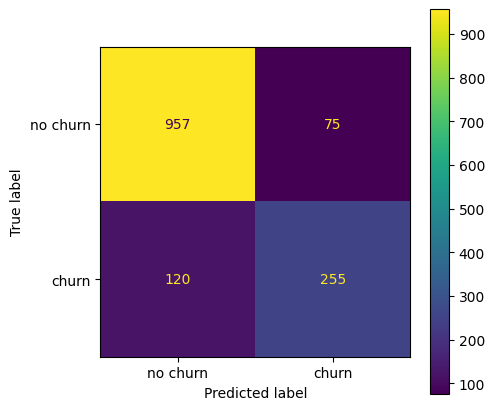

In [16]:
cm = confusion_matrix(y_test, y_pred)
mapping = {0: "no churn", 1: "churn"}  

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[mapping[i] for i in range(len(mapping))])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax)

plt.show()

#### feature importances

In [18]:
importances = pd.DataFrame({'feature': column_trans.get_feature_names_out(input_features=X_train.columns), 'importance': np.round(pipe.named_steps['randomforestclassifier'].feature_importances_, 3)})
importances = importances.sort_values('importance', ascending=False)
importances.head(6)

feature  importance
31                   remainder__numTechTickets       0.212
27                           remainder__tenure       0.153
29                     remainder__TotalCharges       0.146
28                   remainder__MonthlyCharges       0.085
7   onehotencoder__InternetService_Fiber optic       0.052
22            onehotencoder__Contract_Two year       0.043

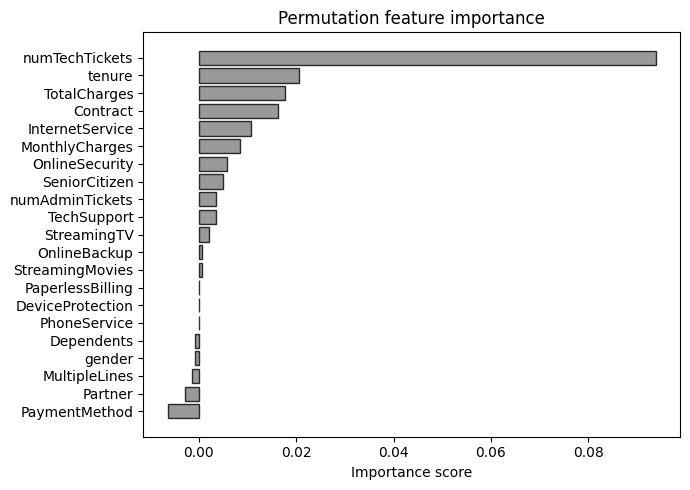

In [19]:
import rfpimp
imp = rfpimp.importances(pipe, X_test,y_test)

fig, ax = plt.subplots(figsize=(7,5))

ax.barh(imp.index, imp['Importance'], height=0.8, facecolor='grey', alpha=0.8, edgecolor='k')
# ax.stem(imp.index, imp['Importance'], height=0.8, facecolor='grey', alpha=0.8, edgecolor='k')
ax.set_xlabel('Importance score')
ax.set_title('Permutation feature importance')
# ax.text(0.8, 0.15, 'ngere', fontsize=12, ha='center', va='center',transform=ax.transAxes, color='grey', alpha=0.5)
plt.gca().invert_yaxis()

fig.tight_layout()

#### tree

In [21]:
tree_classifier = pipe.named_steps['randomforestclassifier'].estimators_[0]

dot_data = StringIO()

export_graphviz(
    tree_classifier,
    out_file=dot_data,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=column_trans.get_feature_names_out(input_features=X_train.columns),
    class_names=['0', '1']
)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
image = Image(graph.create_png())
display(image)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.957959 to fit



#### predict

In [81]:
test = pd.read_csv('test.csv')
X = test.drop(columns = 'customerID')

In [82]:
churn = pipe.predict(X)
churn = pd.Series(churn)
churn

0    0
1    0
2    0
3    0
4    1
5    1
6    0
7    0
dtype: int32

In [83]:
test['churn'] = churn
mapping = {1: 'Yes', 0: 'No'}
test['churn'] = test['churn'].replace(mapping)


In [84]:
test.head(1)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   

      MultipleLines InternetService OnlineSecurity  ... StreamingTV  \
0  No phone service             DSL             No  ...          No   

  StreamingMovies        Contract PaperlessBilling     PaymentMethod  \
0              No  Month-to-month              Yes  Electronic check   

  MonthlyCharges TotalCharges numAdminTickets  numTechTickets  churn  
0          29.85        29.85               0               0     No  

[1 rows x 23 columns]